In [1]:
import numpy as np
from scipy.spatial.distance import cdist, pdist, squareform
import pandas as pd
import gseapy as gp
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy, scprep, phate, sklearn
import leidenalg


In [2]:
methods = ['GSPA_QR', 'GSPA', 'Eigenscore', 'GAE_noatt_Ggene', 'MAGIC', 'DiffusionEMD', 'GFMMD', 'Signals', 'Node2Vec_Ggene', 'GAE_att_Ggene', 'cNMF', 'siVAE', 'SIMBA']

In [28]:
gene_sets_of_interest = {
    '5' : ['Interferon alpha/beta signaling',
       'Antiviral mechanism by interferon-stimulated genes']
}

In [4]:
colors = {'mustard': '#E1AD01', 'berry': '#AC2F3D', 'teal': '#216E76', 'purple':'#502A4F', 'forest': '#065535', 'light forest': '#519167',
          'light yellow': '#E3BC81', 'light berry': '#c7505d', 'light teal': '#81ABA1', 'light purple': '#95636E', 'black': '#000000', 'gray':'#808080',
          'sienna': 'sienna', 'white': 'white', 'midnightblue':'midnightblue', 'palevioletred':'palevioletred', 'brown':'brown', 'orange':'orange'}

In [5]:
names = ['GSPA_QR', 'DiffusionEMD', 'MAGIC','Signals', 'GSPA', 'GAE_att_Ggene',
       'GAE_noatt_Ggene', 'Node2Vec_Ggene', 'GFMMD', 'Eigenscore', 'cNMF', 'SIMBA', 'siVAE']

clist = np.array(['black', 'light yellow', 'purple', 'forest', 'mustard', 'teal',
         'berry', 'gray', 'light purple', 'light forest', 'light teal', 'sienna', 'white', 'midnightblue', 'palevioletred', 'brown'])

clist = dict(zip(names,[colors[x] for x in clist]))

In [6]:
for i in range(9):
    clist[f'Cell cluster {i}']= 'red'

/tmp/ipykernel_1651238/965182865.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(gene_set_df, y=gene_set_df.index, x='Combined Score', orient='h', ax=ax[i], palette=clist)
/tmp/ipykernel_1651238/965182865.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(gene_set_df, y=gene_set_df.index, x='Combined Score', orient='h', ax=ax[i], palette=clist)


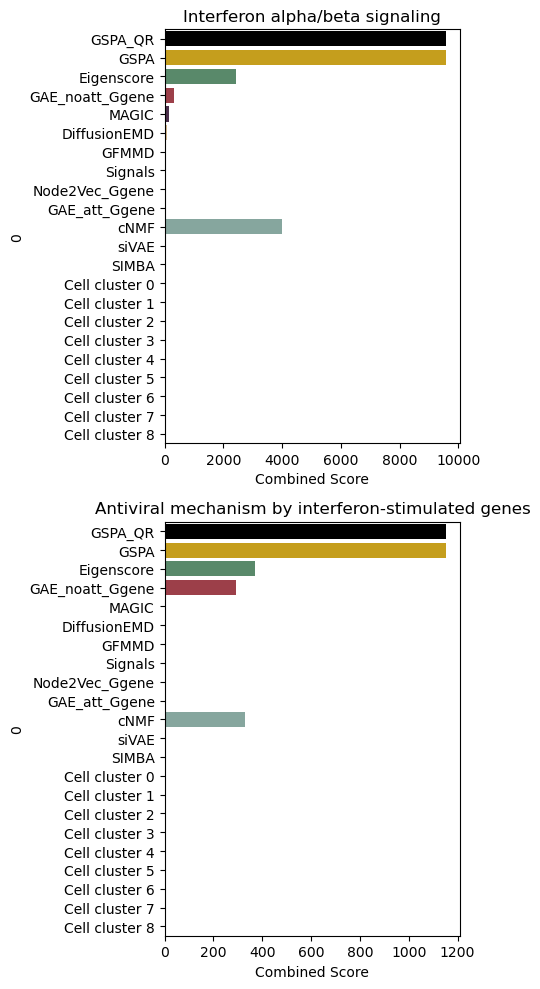

In [29]:
all_enrichment_scores = {}
enrichment_scores = {}
gene_of_interest = 'Irf7'
my_gene_cluster = pd.read_csv('results/gene_summary.csv', index_col=0).loc[gene_of_interest]['gene_clusters'].astype(int).astype(str)
all_loc_genes = {}

for method in methods:
    if method == 'cNMF':
        gene_spectra_scores = pd.read_csv('results/cnmf_results_numiter_100/t_cell_cnmf/t_cell_cnmf.spectra.k_6.dt_0_1.consensus.txt', sep='\t', index_col=0)
        gene_spectra_scores = (gene_spectra_scores / gene_spectra_scores.sum(axis=0)).T
        cluster_of_interest = gene_spectra_scores.loc['Irf7'].idxmax()
        
        threshold = np.percentile(gene_spectra_scores[cluster_of_interest], q=90)
        loc_genes = gene_spectra_scores[gene_spectra_scores[cluster_of_interest] > threshold].index.tolist()
        
    elif method == 'GSPA_QR':
        results = dict(np.load(f'./results/GSPA_QR_without_regression.npz', allow_pickle=True))
        results['clusters'] = pd.read_csv('results/gene_summary.csv', index_col=0)['gene_clusters'].astype(str).values
        df = pd.DataFrame([results['clusters'].astype(str), results['localization_score']],
          columns=results['genes'], index=['clusters', 'localization_score']).T
        cluster_of_interest = df.loc[gene_of_interest]['clusters']
        threshold = np.percentile(df['localization_score'][df['clusters']== cluster_of_interest], q=90)
        loc_genes = df[(df['clusters'] == cluster_of_interest) & (df['localization_score'] > threshold)].index.tolist()
    else:
        results = np.load(f'./results/{method}_gene_embedding.npz', allow_pickle=True)
        df = pd.DataFrame([results['clusters'].astype(str), results['localization_score']],
          columns=results['genes'], index=['clusters', 'localization_score']).T
        cluster_of_interest = df.loc[gene_of_interest]['clusters']
        threshold = np.percentile(df['localization_score'][df['clusters']== cluster_of_interest], q=90)
        loc_genes = df[(df['clusters'] == cluster_of_interest) & (df['localization_score'] > threshold)].index.tolist()
    
    all_loc_genes[method] = loc_genes
    enr = gp.enrichr(gene_list=loc_genes, # or "./tests/data/gene_list.txt",
                     gene_sets=['BioPlanet_2019'],
                     organism='mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                     outdir=None, # don't write to disk,
                     cutoff = 1.0,
                    )
    
    enrichment_scores[method] = enr.results[enr.results['Term'].isin(gene_sets_of_interest[my_gene_cluster])][['Term', 'Combined Score', 'Adjusted P-value']]
all_enrichment_scores[gene_of_interest] = enrichment_scores

df = pd.concat([pd.concat((all_enrichment_scores[gene_of_interest][method].reset_index(drop=True),
                    pd.Series([method]*len(gene_sets_of_interest[my_gene_cluster]))), axis=1) 
                   for method in methods])

df['-log10(Adjusted P-value)'] = -1 * np.log10(df['Adjusted P-value'])

fig, ax = plt.subplots(2, int(np.ceil(len(gene_sets_of_interest[my_gene_cluster])/2)),
                       figsize=(int(np.ceil(len(gene_sets_of_interest[my_gene_cluster])/2))*5,10)); ax=ax.flatten()

init = pd.DataFrame([methods + [f'Cell cluster {i}' for i in range(9)], [0]*(len(methods)+9)]).T 
init.columns = [0, 'Combined Score']
init = init.set_index(0)

for i,gene_set in enumerate(gene_sets_of_interest[my_gene_cluster]):

    gene_set_df = df[df['Term'] == gene_set][[0, 'Combined Score']]
    gene_set_df = gene_set_df.set_index(0)
    gene_set_df = (init + gene_set_df).fillna(0)
    gene_set_df = gene_set_df.loc[methods + [f'Cell cluster {i}' for i in range(9)]]
    
    sns.barplot(gene_set_df, y=gene_set_df.index, x='Combined Score', orient='h', ax=ax[i], palette=clist)
    ax[i].set_title(gene_set.split(',')[0])
    
plt.tight_layout()
fig.savefig(f'figures/localized_genes_cluster_{my_gene_cluster}.png', dpi=500)

## visualize localized genes

In [3]:
import scanpy
acute = scanpy.read_h5ad('data/acute_tcells.h5ad')
chronic = scanpy.read_h5ad('data/chronic_tcells.h5ad')

In [4]:
adata = scanpy.concat((acute,chronic))
adata.obs['batch'] = adata.obs['batch'].astype('category')

In [11]:
import phate
phate_op = phate.PHATE(random_state=42, n_jobs=-1, knn=30)
adata.obsm['X_phate'] = phate_op.fit_transform(adata.to_df())

Calculating PHATE...
  Running PHATE on 39704 observations and 14152 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 72.45 seconds.
    Calculating KNN search...
    Calculated KNN search in 102.06 seconds.
    Calculating affinities...
    Calculated affinities in 10.09 seconds.
  Calculated graph and diffusion operator in 186.08 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 90.81 seconds.
    Calculating KMeans...
    Calculated KMeans in 9.31 seconds.
  Calculated landmark operator in 101.73 seconds.
  Calculating optimal t...
    Automatically selected t = 22
  Calculated optimal t in 209.50 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.79 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.62 seconds.
Calculated PHATE in 503.75 seconds.


In [10]:
hvgs = results['genes']

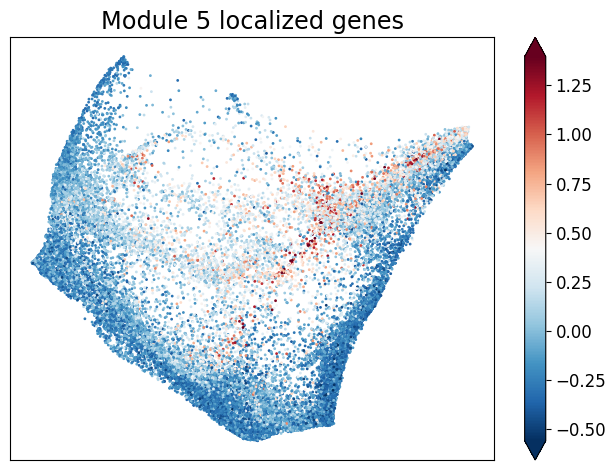

In [18]:
for method in ['GSPA_QR']:
    scanpy.tl.score_genes(adata, gene_list=all_loc_genes[method],
                              random_state=0, score_name=f'{method}_ifn_score',
                              gene_pool=hvgs, n_bins=int(len(hvgs) * 0.25))
    
    scprep.plot.scatter2d(adata.obsm['X_phate'],
                          c=adata.obs[f'{method}_ifn_score'], cmap='RdBu_r',
                          vmax=np.percentile(adata.obs[f'{method}_ifn_score'], 99.9),
                          vmin=np.percentile(adata.obs[f'{method}_ifn_score'], 0.1),
                          title=f'Module 5 localized genes', ticks=None, legend_loc=(1.05,0), dpi=200,
                          filename=f'./figures/module_5_localized_genes.png')